# RSIをプロットする

In [8]:
# Google　Colaboratory で実行する場合はインストールする
if "google.colab" in str(get_ipython()):
    !pip install japanize_matplotlib
    !pip install mplfinance

In [9]:
import numpy as np
import pandas as pd
import mplfinance as mpf
from utils import get_finance_data

In [10]:
# 銘柄名、期間、保存先ファイル
ticker_symbol = "NVDA"
start = "2021-05-01"
end = "2021-06-30"

# データを取得する
df = get_finance_data(ticker_symbol, start=start, end=end, savedir="../data")
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-30,153.649994,149.970001,151.744995,150.095001,20191200.0,149.990234
2021-05-03,152.467499,147.875000,151.250000,148.367493,20391200.0,148.263931
2021-05-04,146.375000,140.102493,146.372498,143.512497,40532400.0,143.412323
2021-05-05,148.134995,143.875000,147.089996,144.585007,29202400.0,144.484070
2021-05-06,145.712494,142.179993,144.952499,145.229996,19338000.0,145.128616


## RSIを求める
RSIには様々な計算方法があり[[1](https://www.macroption.com/rsi-calculation/)]、ここでは[Relative Strength Index (RSI)](https://www.investopedia.com/terms/r/rsi.asp)で示されている方法で計算してみます。

- [pandas.Series.diff](https://pandas.pydata.org/docs/reference/api/pandas.Series.diff.html#pandas.Series.diff)

In [11]:
def get_rsi(close_prices: pd.Series, n=14):
    """RSI(相対力指数)を計算する
    RS＝（n日間の終値の上昇幅の平均）÷（n日間の終値の下落幅の平均）
    RSI= 100　-　（100　÷　（RS+1））

    参考文献：
      - https://info.monex.co.jp/technical-analysis/indicators/005.html
      - https://www.investopedia.com/terms/r/rsi.asp <-- 以下のコードの記号はこのページのものを使用

    Args:
        close_price (pd.Series): 終値の系列
        days (str): n日間, optional, default is 14.

    Returns:
        rsi(pd.Series): RSI
    """
    close_prices_diff = close_prices.diff(periods=1)[1:]
    fist_n_days_diff = close_prices_diff[: n + 1]
    previous_average_gain, previous_average_loss = 0, 0
    rsi = np.zeros_like(close_prices)

    for i in range(len(close_prices)):
        if i < n:
            previous_average_gain = fist_n_days_diff[fist_n_days_diff >= 0].sum() / n
            previous_average_loss = -fist_n_days_diff[fist_n_days_diff < 0].sum() / n
            rsi[i] = 100.0 - 100.0 / (1 + previous_average_gain / previous_average_loss)
        else:
            if (cpd_i := close_prices_diff[i - 1]) > 0:
                current_gain = cpd_i
                current_loss = 0.0
            else:
                current_gain = 0.0
                current_loss = -cpd_i

            previous_average_gain = (previous_average_gain * (n - 1) + current_gain) / n
            previous_average_loss = (previous_average_loss * (n - 1) + current_loss) / n
            rsi[i] = 100.0 - 100.0 / (1 + previous_average_gain / previous_average_loss)
    return rsi

## OHLC チャートと並べてプロットする

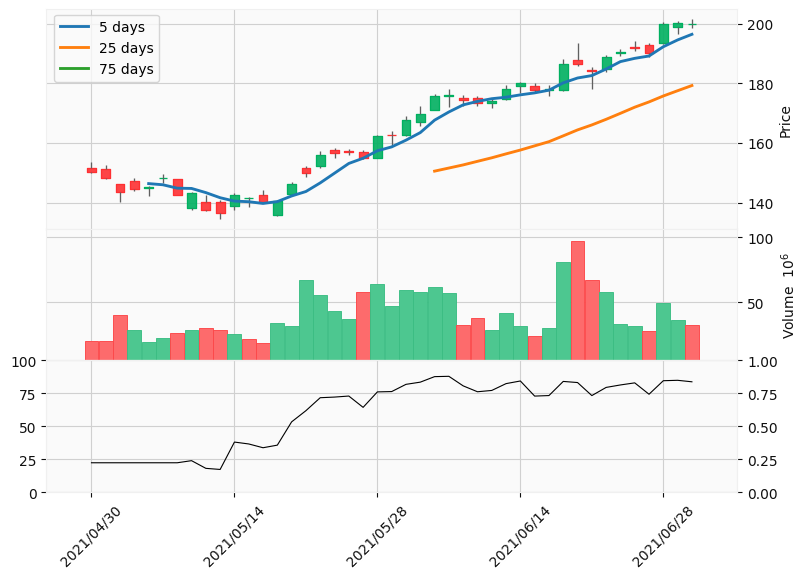

In [12]:
df["rsi"] = get_rsi(df["Close"], n=7)

# RSIのグラフを追加する
apd = mpf.make_addplot(
    df["rsi"], panel=2, color="#000", ylim=(0, 100), secondary_y=True, width=0.8
)

# グラフを作成
fig, axes = mpf.plot(
    df,
    type="candle",
    style="yahoo",
    volume=True,
    mav=[5, 25, 75],
    addplot=apd,
    panel_ratios=(1, 0.6),
    datetime_format="%Y/%m/%d",
    returnfig=True,
    figscale=1.2,
)
fig.legend(
    [f"{days} days" for days in [5, 25, 75]], bbox_to_anchor=(0.0, 0.78, 0.305, 0.102)
)

## 条件を満たした範囲を塗りつぶす
「RSIが●×以上になった」「価格が●×を超えた」など、条件が満たされた期間を塗りつぶしてわかりやすくしたいです。
ここでは、80を超えた区間を塗りつぶしてみます。

### 塗りつぶし範囲の区間のリストを作る

In [13]:
cond_true_spans = []
span = None
is_true_span = False

for i, rsi_i in enumerate(df["rsi"]):
    if rsi_i > 80 and not is_true_span:
        is_true_span = True
        span = [i, 0]
    elif rsi_i < 80 and is_true_span:
        is_true_span = False
        span[1] = i - 1
        cond_true_spans.append(span)
    else:
        pass

### グラフの塗りつぶしをする
[matplotlib.pyplot.axvspan](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvspan.html)

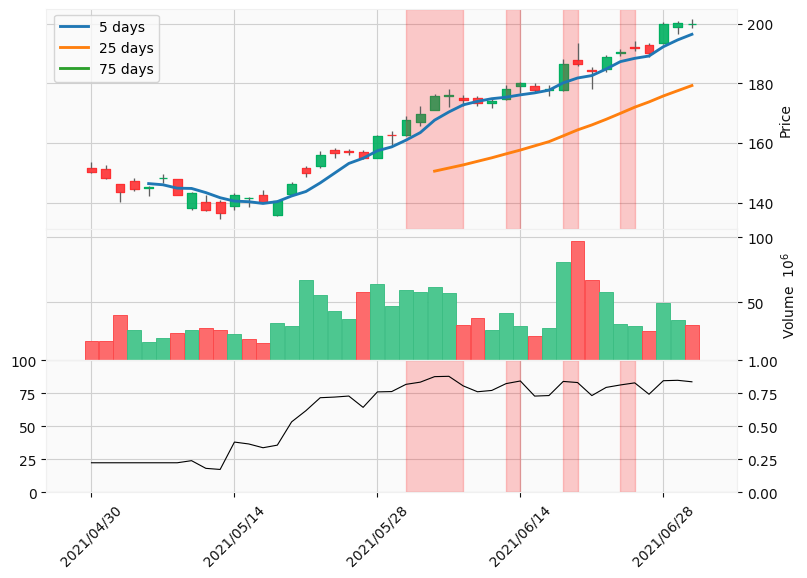

In [14]:
apd = mpf.make_addplot(
    df["rsi"], panel=2, color="#000", ylim=(0, 100), secondary_y=True, width=0.8
)

fig, axes = mpf.plot(
    df,
    type="candle",
    style="yahoo",
    volume=True,
    mav=[5, 25, 75],
    addplot=apd,
    panel_ratios=(1, 0.6),
    datetime_format="%Y/%m/%d",
    returnfig=True,
    figscale=1.2,
)
fig.legend(
    [f"{days} days" for days in [5, 25, 75]], bbox_to_anchor=(0.0, 0.78, 0.305, 0.102)
)

for span in cond_true_spans:
    axes[0].axvspan(span[0], span[1], color="red", alpha=0.2)
    axes[-1].axvspan(span[0], span[1], color="red", alpha=0.2)